In [18]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import glob
import sys
import string
import scipy
import scipy.io
import copy
import random
reload(sys)
sys.setdefaultencoding('utf8')
sys.getdefaultencoding()


In [2]:
filenames = glob.glob("/Users/Ruby/Desktop/project5/data/synopsis/*.txt")

In [3]:
synopses = [[] for i in range(len(filenames))]
for i in range(len(filenames)):
    file = open(filenames[i],"r")
    synopses[i] = file.read()

In [4]:
#load nltk's English stopwords as variable called 'stopwords'
#stopwords = nltk.corpus.stopwords.words('english')

#from nltk.corpus import stopwords
#stopwords = set(stopwords.words('english'))
from stop_words import get_stop_words
stop_words = get_stop_words('en')
stop_words = get_stop_words('english')

In [5]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [6]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [7]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    i = "".join(i)
    allwords_stemmed = "".join(tokenize_and_stem(i)) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend("".join(allwords_stemmed)) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [8]:

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index= totalvocab_tokenized)
print 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8,
                                 min_df=0.2, stop_words=get_stop_words('english'),
                                 use_idf=True, tokenizer=tokenize_and_stem)

tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

In [10]:
scipy.io.mmwrite('/Users/Ruby/Desktop/tfidf.mtx',tfidf_matrix )

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
np.round(dist, 2)
import pandas as pd
dist = pd.DataFrame(dist, index = np.arange(446))
dist.to_csv('/Users/Ruby/Desktop/project5/synopsis_document_association.csv', sep=',')

In [12]:
terms = tfidf_vectorizer.get_feature_names()

In [13]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [14]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [15]:
films = { 'synopsis': synopses, 'cluster': clusters }

frame = pd.DataFrame(films, index = [clusters] , columns = ["synopsis","cluster"])

In [16]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % terms[ind], end=',')


    print() #add whitespace
    print() #add whitespace
    
print()
print()

In [19]:
cluster_names = {0: ",".join([terms[i] for i in order_centroids[0, :3]])}
for j in [1,2,3,4]:
    cluster_names[j] = ",".join([terms[i] for i in order_centroids[j, :3]])
titles = []
for z in synopses:
    z = "".join(z)
    titles.append(z.replace("'","").split('\"',2)[1].replace('/',"").replace(', The',"").replace(', A',""))
for i in random.sample(xrange(446), 386):
    titles[i] = ""
title = []
for z in synopses:
    z = "".join(z)
    title.append(z.replace("'","").split('\"',2)[1].replace('/',"").replace(', The',"").replace(', A',""))


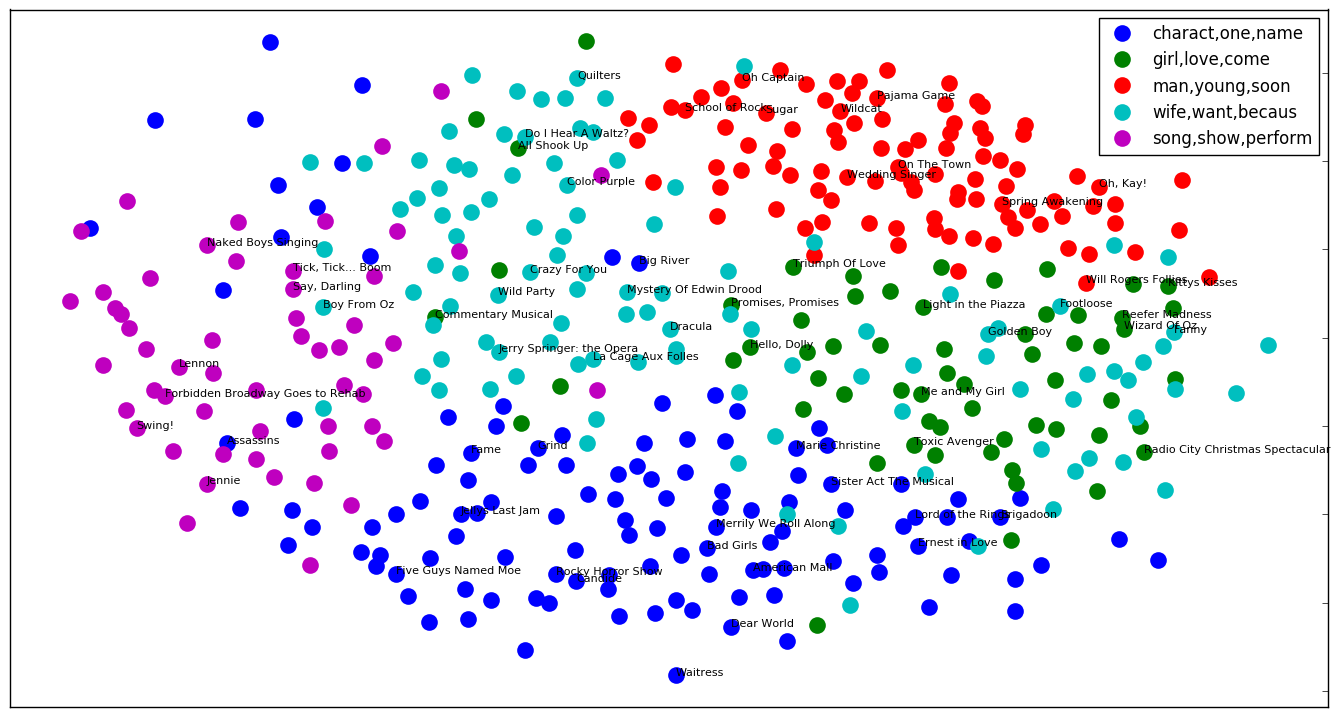

In [21]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]



#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title = titles, real = title)) 

#group by cluster
groups = df.groupby('label')


# set up plot

fig = plt.figure()
fig.set_size_inches(17,9)
ax = plt.subplot(1,1,1) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
fig.savefig('/Users/Ruby/Desktop/project5/clusters_noaxes.png', dpi=200)

In [22]:
group_title = []
for name, group in groups
    group_title.append(group['real'])

In [23]:
order_centroids[2, :5]

array([ 81, 144, 115,  50,  16])

In [28]:
[terms[i] for i in order_centroids[2, :10]]

[u'man',
 u'young',
 u'soon',
 u'girl',
 u'began',
 u'decid',
 u'woman',
 u'went',
 u'came',
 u'friend']

In [29]:
[terms[i] for i in order_centroids[1, :10]]

[u'girl',
 u'love',
 u'come',
 u'time',
 u'young',
 u'man',
 u'friend',
 u'take',
 u'find',
 u'want']

In [30]:
[terms[i] for i in order_centroids[0, :10]]

[u'charact',
 u'one',
 u'name',
 u'stori',
 u'main',
 u'will',
 u'life',
 u'local',
 u'play',
 u'time']

In [31]:
[terms[i] for i in order_centroids[3, :10]]

[u'wife',
 u'want',
 u'becaus',
 u'one',
 u'husband',
 u'father',
 u'love',
 u'daughter',
 u'now',
 u'life']

In [32]:
[terms[i] for i in order_centroids[4, :10]]

[u'song',
 u'show',
 u'perform',
 u"'s",
 u'stage',
 u'time',
 u'one',
 u'play',
 u'new',
 u'work']